## Problema de negócio

O cfo da empresa fez uma reunião com todos os gerentes de loja e pediu para que cada um dele trouxesse uma previsão diária das próximas 6 semanas de vendas.
Cada gerente entrou em contato com você para requisitar a previsão de vendas.

A motivação.
- Qual o contexto?
Reunião de resultados mensais.

A causa raiz do problema.
- Porque fazer uma previsão de vendas?
Previsão de quanto de dinheiro entrará para fazer a reforma da loja.

Quem é o dono do problema?
- Quem será o stakeholder?
CFO ou diretor que tem a regra de negócio.

Formato da solução
- Qual é a granularidade?
= Previsão de vendas dia por loja nas próximas 6 semanas.
- Tipo do problema.
= Previsão de vendas
- Potenciais Métodos.
= Time series, regressão, redes neurais
- Formato da entrega.
= Receber pelo celular a previsão.

Ciclo CRISP. Cross-Industry Process - DS
- 1 versão end to end simplificada da solução
- Velocidade na entrega de valor.
- Mapemaneto de todos os possíveis problemas.

Etapas:
1 - Questão de negócio -> Entendimento do negócio -> Coleta de dados -> Limpeza dos dados -> Exploração dos dados -> Modelagem dos dados -> Algoritmos de machine learning -> Avaliação do algorítimo -> Modelo em prod

## 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import inflection 
import math 
import matplotlib as mpl
from IPython.display import Image

In [2]:
mpl.rcParams['figure.figsize'] = [10, 10]

## 0.1 Helper Functions

## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
339601,444,5,2014-09-12,11189,1425,1,0,0,0,c,a,1700.0,11.0,2009.0,0,NaN,NaN,NaN


## 1.0 Data descriptions

In [5]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore ( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [10]:
#transforming date time
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA
competition_distance -> Assumir que lojas que estão muito distantes não são consideradas competidoras por isso é NA.

competition_open_since_month -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

competition_open_since_year -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo2_since_week ->  Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo2_since_year -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo_interval -> Split da coluna e criar uma lista, caso minha data esteja na lista, a promoção 2 foi ativa.

In [12]:
#competition_distance - distance in meters to the nearest competitor store
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#promo2_since_year        
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
#promo_interval     
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
                                                            in x['promo_interval'].split(',')
                                                            else 0, axis=1)

## 1.6 Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.149166,0.0,0.356252,1.969586,1.879273


## 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

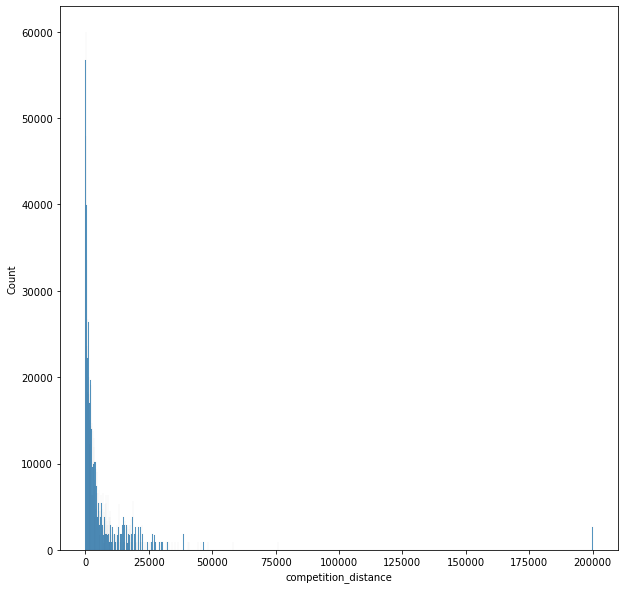

In [17]:
sns.histplot( df1['competition_distance'], kde=False )

<AxesSubplot:xlabel='assortment', ylabel='sales'>

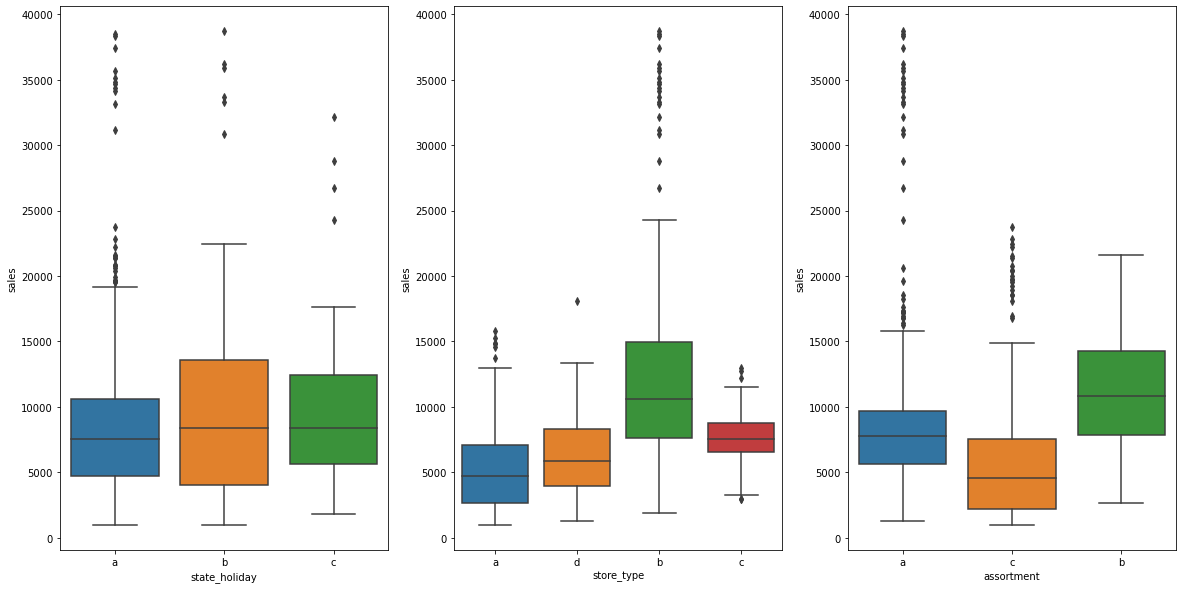

In [18]:
plt.figure(figsize=(20, 10))

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )
plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )


## HIPOTESIS MINDMAP

- Fenômeno: Qual modelo estou modelando?
- Agentes: Quem são os agentes que atuam sobre o fenômeno de interesse?
- Atributos dos Agentes: Qual a descrição dos agentes?
- Lista de Hipóteses: Hipóteses para validar com dados

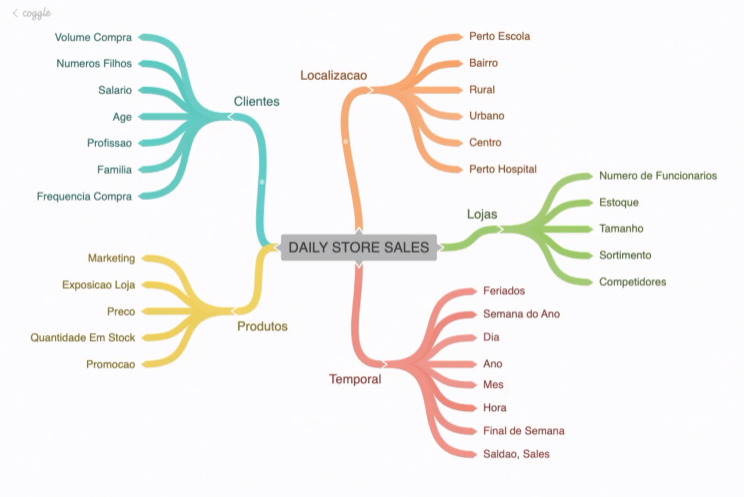

In [19]:
Image('D:\data-science\projects-datascience\ds-producao\img\MIND_MAP.PNG')

## 2.1 Hypotheses creation

### 2.1.1 Store Hipotheses

1 - Stores with a higher number of employees should sell more.

2 - Stores with larger inventory capacity should sell more.

3 - Stores with larger size should sell more.

4 - Stores with a wider assortment should sell more.

5 - Stores with closer competitors should sell less.

6 - Stores with competitors that have been around longer should sell more.

### 2.1.2 Product Hipotheses

1 - Stores that invest more in marketing should sell more.

2 - Stores with greater product exposure should sell more.

3 - Stores with lower-priced products should sell more.

4 - Stores with more aggressive promotions (larger discounts) should sell more.

5 - Stores with promotions active for longer periods should sell more.

6 - Stores with more days of promotion should sell more.

7 - Stores with more consecutive promotions should sell more.

### 2.1.3 Time Hipotheses

1 - Stores open during the Christmas holiday should sell more.

2 - Stores should sell more over the years.

3 - Stores should sell more in the second half of the year.

4 - Stores should sell more after the 10th of each month.

5 - Stores should sell less on weekends.

6 - Stores should sell less during school holidays.

### 2.1.4 Final Hipotheses

1 - Stores with a wider assortment should sell more.

2 - Stores with closer competitors should sell less.

3 - Stores with competitors that have been around longer should sell more.

4 - Stores with promotions active for longer periods should sell more.

5 - Stores with more days of promotion should sell more.

6 - Stores with more consecutive promotions should sell more.

7 - Stores open during the Christmas holiday should sell more.

8 - Stores should sell more over the years.

9 - Stores should sell more in the second semester of the year.

10 - Stores should sell more after the 10th of each month.

11 - Stores should sell less on weekends.

12 - Stores should sell less during school holidays.

## 2.2 Feature Engineering

In [20]:
df2 = df1.copy()

In [21]:
#year
df2['year'] = df2['date'].dt.year
#day
df2['day'] = df2['date'].dt.day
#month
df2['month'] = df2['date'].dt.month
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )
#assortiment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 Variable Filtering

In [23]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,day,month,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,31,7,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Filtering rows

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,day,month,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,31,7,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.2 Selecting Columns

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## 4.0 Exploratory data analysis

### Goals: 

1 - Gain business experience.

2 - Validate business hypotheses ( Insights )

3 - Variables importants for the model.


In [26]:
df4 = df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Variável resposta

c:\Users\Iann\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

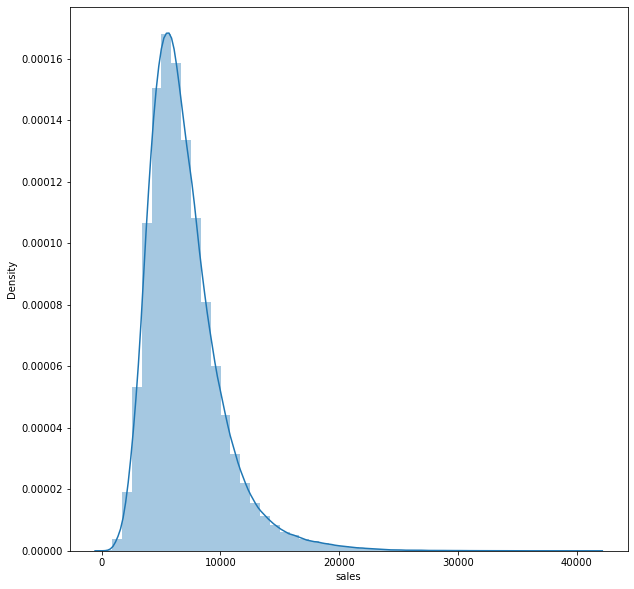

In [27]:
sns.distplot(df4['sales'])

#### 4.1.2 Variável numérica

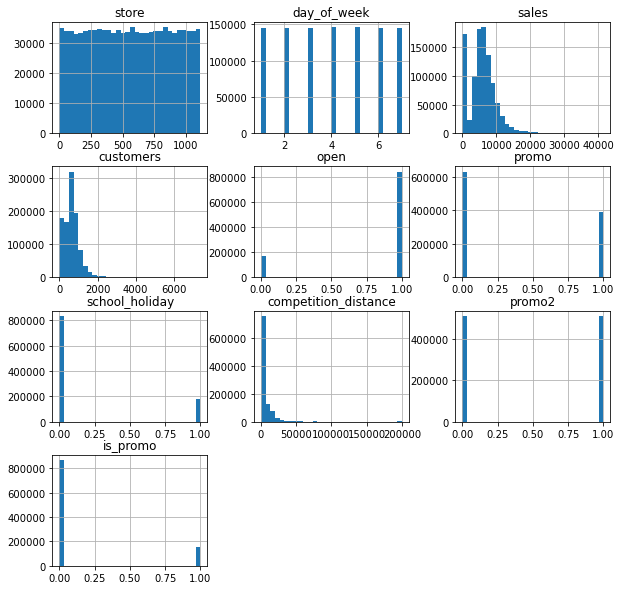

In [28]:
num_attributes.hist(bins=30);
mpl.rcParams['figure.figsize'] = [20, 17]

plt.show()

#### 4.1.3 Variável categórica

In [29]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

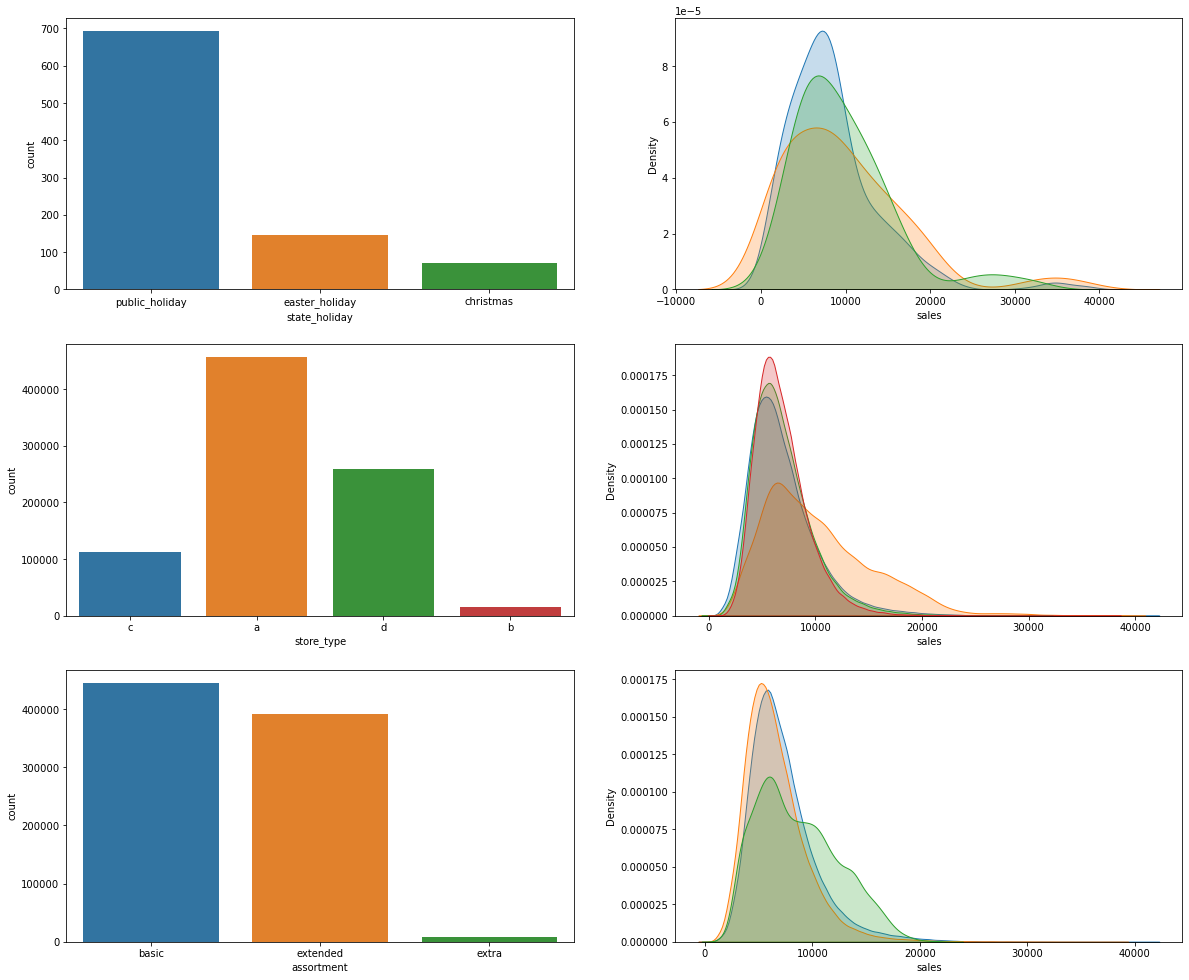

In [30]:
warnings.simplefilter(action="ignore", category=FutureWarning)
# state holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label= 'christmas', shade=True)

#store type

plt.subplot(3 , 2, 3)
sns.countplot(df4['store_type'])


plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label= 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label= 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label= 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label= 'd', shade=True)

#assortiment


plt.subplot(3 , 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label= 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label= 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label= 'extra', shade=True)



### 4.2 Analise Bivariada

#### H1. Lojas com maior sortimentos deveriam vender mais
***FALSA*** Lojas com MAIOR sortimento vendem MENOS.

<AxesSubplot:xlabel='year_week'>

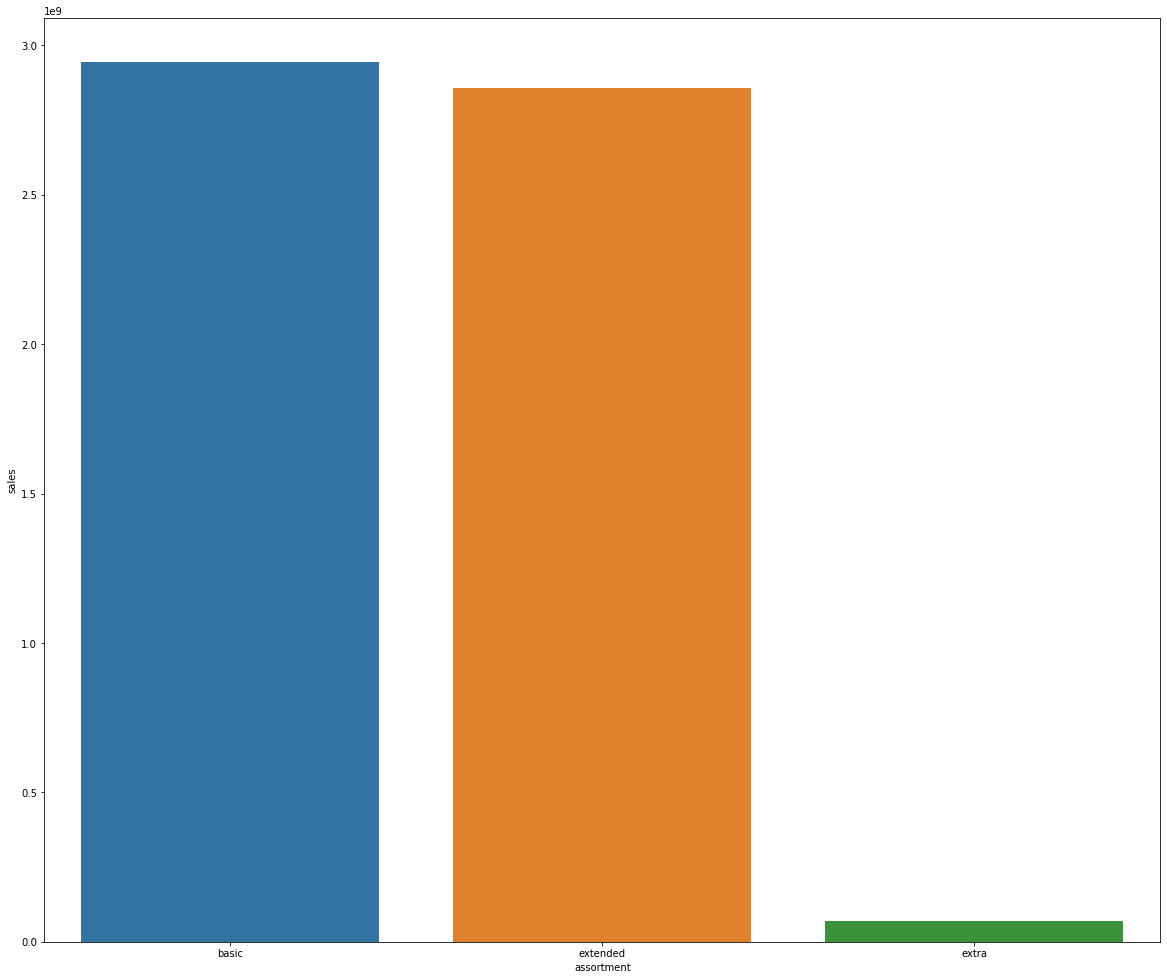

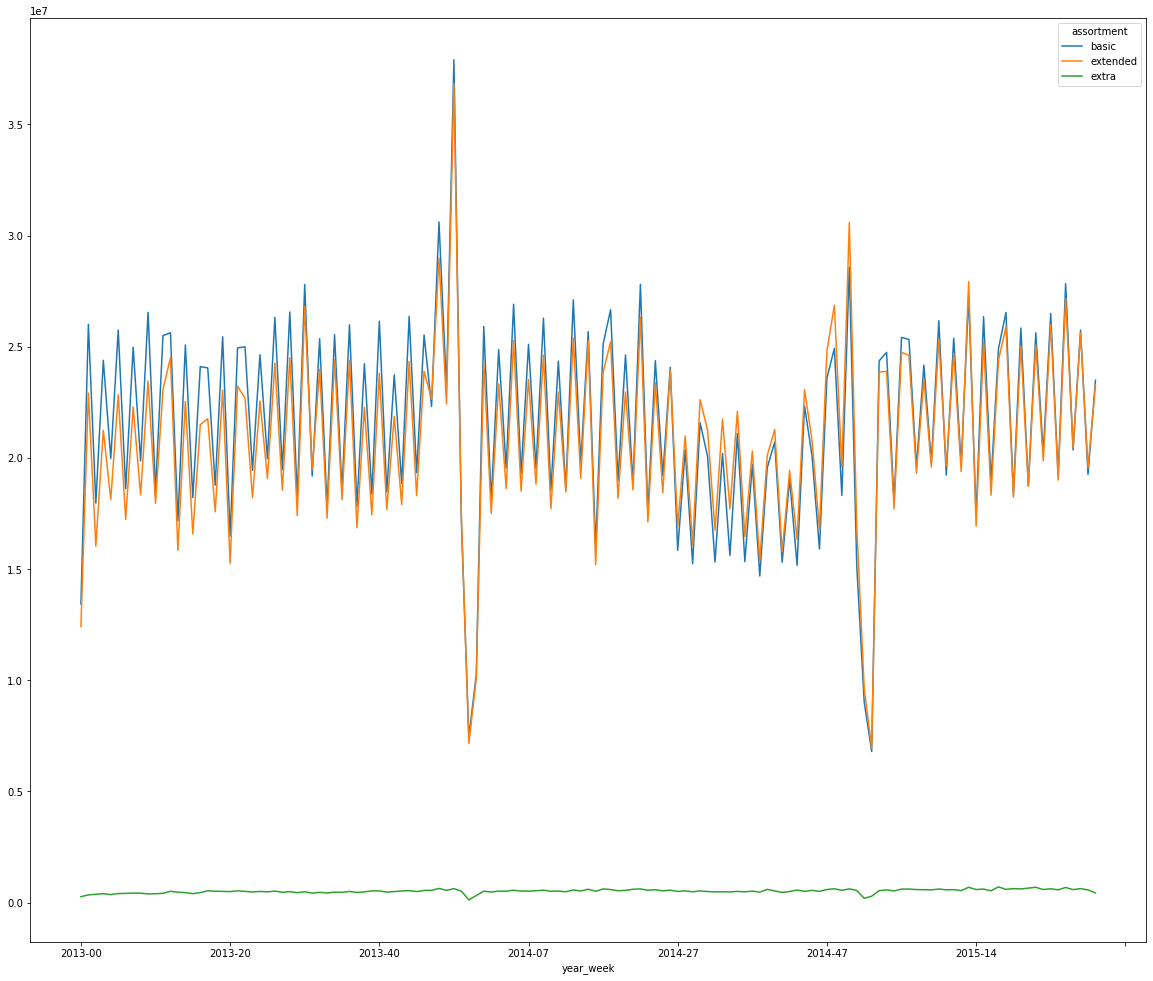

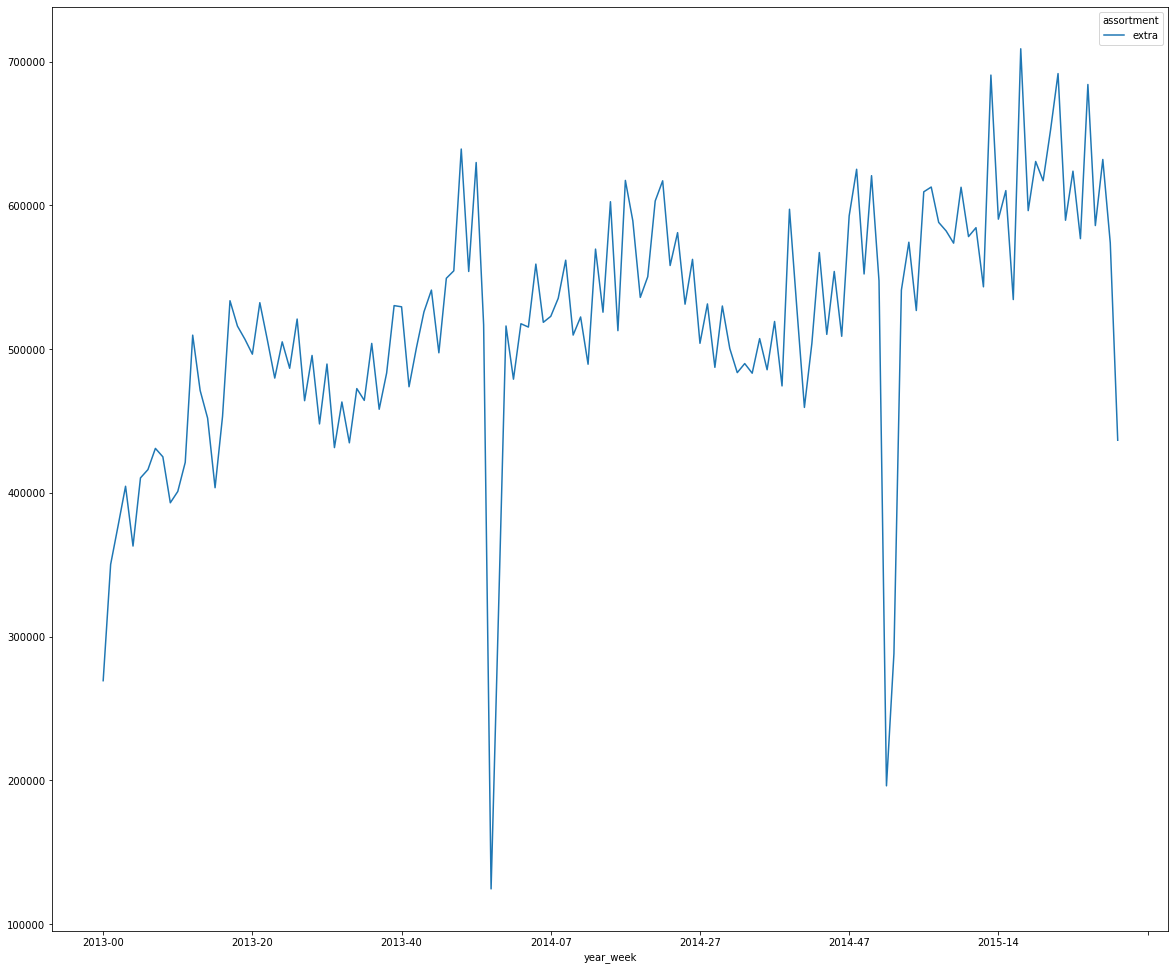

In [34]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### H2. Lojas com competidores mais próximos deveriam vender menos.
***FALSA*** Lojas com competidores mais próximos vendem MAIS.

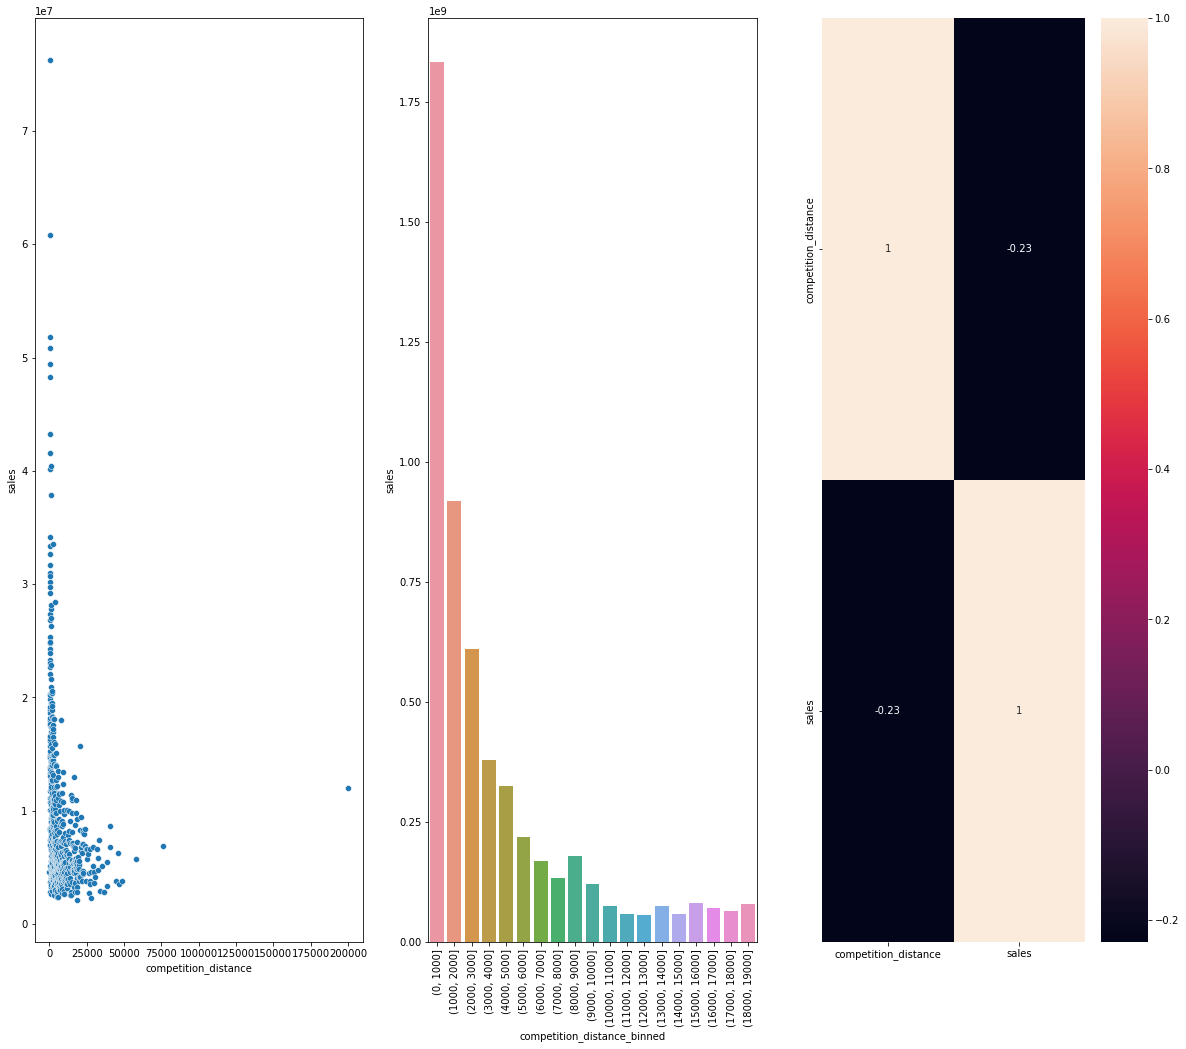

In [44]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

# calculo de força da correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### H3. Lojas com competidores à mais tempo deveriam vender mais.
***FALSA*** Lojas com competidores a mais tempo vendem MENOS

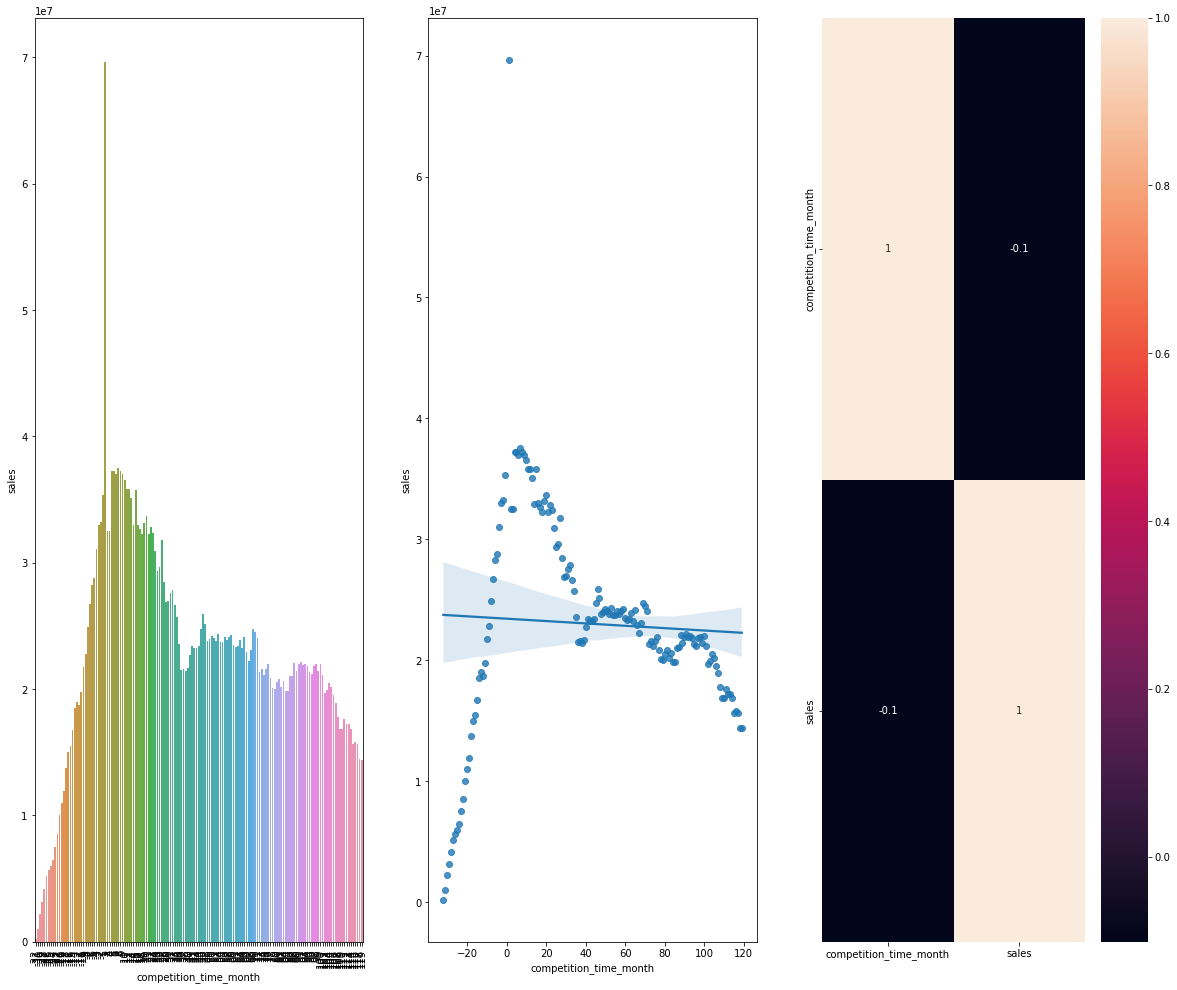

In [62]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
